In [1]:
%load_ext autoreload
%autoreload 2
from calibrate import *
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import skimage
import imageio

In [48]:
master_bias('/home/felix/PiCamera_DSLR_like_controller/calibration/Bias', '/home/felix/PiCamera_DSLR_like_controller/calibration/computed')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')


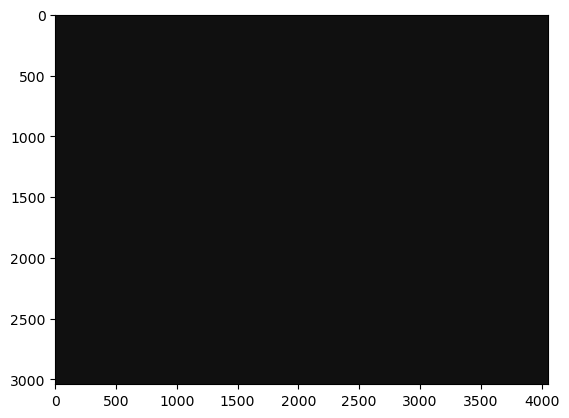

In [5]:
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')
plt.imshow(cv.convertScaleAbs(mbias, alpha=(255.0/65535.0)).astype(np.uint8))

In [4]:
master_flat(img_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/Flats',out_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/computed', mbias='/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy',mdark=None)
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')


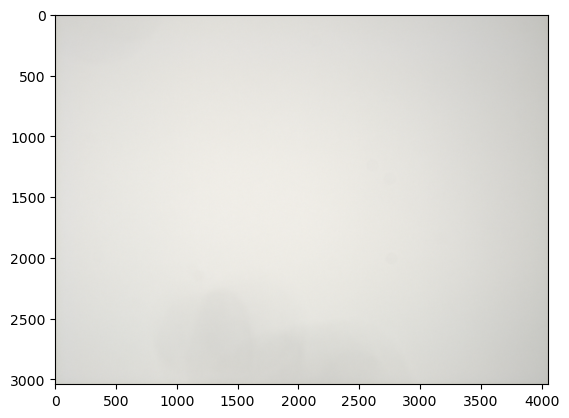

In [8]:
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')
plt.imshow(mflat)

### Couldnt crack lens dist

# Image gen
(shitty)HDR first gives better results

In [3]:
rasp_dir = '/media/raspberry/felix/Images/img_5/'
name = 'chalk_fancy'
img_dir = '/home/felix/Pictures/'+name
completed_pictures = '/home/felix/Pictures/'+name+'/completed/'
# TODO: Add file in raspi to tell when to stop rsync

if rasp_dir[-1] != '/': rasp_dir+='/'
if not os.path.isdir(img_dir): os.mkdir(img_dir)
if not os.path.isdir(completed_pictures): os.mkdir(completed_pictures)

Below is meant to be run during imaging to make retrieval take less time

In [4]:
# Copy images persistently from raspi to pc
while True:
    cmd = 'rsync -a -P -z {} {}'.format(rasp_dir, img_dir) 
    os.system(cmd)
    # The flag set during imaging to tell wheter or not still imaging
    with open('/media/raspberry/felix/imaging.txt') as f:
        if 'False' in f.read(): break

sending incremental file list
./
1000_0_0_NoIR.dng
     18.496.120 100%    7,06MB/s    0:00:02 (xfr#1, to-chk=343/345)
1000_0_0_NoIR.dng.jpeg
        847.860 100%    1,40MB/s    0:00:00 (xfr#2, to-chk=342/345)
1020_0_0_NoIR.dng
     18.496.120 100%    5,52MB/s    0:00:03 (xfr#3, to-chk=341/345)
1020_0_0_NoIR.dng.jpeg
        850.175 100%    2,83MB/s    0:00:00 (xfr#4, to-chk=340/345)
1040_0_0_NoIR.dng
     18.496.120 100%    6,47MB/s    0:00:02 (xfr#5, to-chk=339/345)
1040_0_0_NoIR.dng.jpeg
        852.824 100%    1,02MB/s    0:00:00 (xfr#6, to-chk=338/345)
1060_0_0_NoIR.dng
     18.496.120 100%    5,33MB/s    0:00:03 (xfr#7, to-chk=337/345)
1060_0_0_NoIR.dng.jpeg
        860.748 100%    2,01MB/s    0:00:00 (xfr#8, to-chk=336/345)
1080_0_0_NoIR.dng
     18.496.120 100%    5,94MB/s    0:00:02 (xfr#9, to-chk=335/345)
1080_0_0_NoIR.dng.jpeg
        875.407 100%  782,15kB/s    0:00:01 (xfr#10, to-chk=334/345)
1100_0_0_NoIR.dng
     18.496.120 100%    6,88MB/s    0:00:02 (xfr#11, to-chk=333

In [5]:
# These are uint16
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')

def rem_b_f(mbias,mflat,img_dir):
    if not os.path.isdir(os.path.join(img_dir,'preprocessed')): os.mkdir(os.path.join(img_dir,'preprocessed'))
    for i in os.listdir(img_dir):
        try:
            # Check if dir
            # Check if already processed
            # Check if jpeg
            if os.path.isdir(os.path.join(img_dir, i)) or os.path.isfile(os.path.join(img_dir,'preprocessed',i[:-4]+'.dng')) or 'jpeg' in i: 
                pass
            else:
                print('processing ', i)
                processed = (images_to_data(os.path.join(img_dir, i)) - mbias)/mflat
                # Cause images are underexposed
                # TODO: Remove
                processed = processed*10
                processed[processed>65535] = 65535
                processed[processed<0] = 0
                processed = processed.astype(np.uint16)
                imageio.imsave(os.path.join(img_dir,'preprocessed',i[:-4]+'.tiff'), processed)
        except Exception as e:
            print('failed: ', e)
            print(i)

rem_b_f(mbias,mflat,img_dir)


processing  3460_0_0_NoIR.dng
processing  2480_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
2480_0_0_NoIR.dng.jpeg
processing  340_0_0_NoIR.dng
processing  380_0_0_NoIR.dng
processing  3020_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
3020_0_0_NoIR.dng.jpeg
processing  660_0_0_NoIR.dng
processing  1900_0_0_NoIR.dng
processing  3140_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
3140_0_0_NoIR.dng.jpeg
processing  900_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
900_0_0_NoIR.dng.jpeg
processing  2580_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
2580_0_0_NoIR.dng.jpeg
processing  2100_0_0_NoIR.dng
processing  1180_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
1180_0_0_NoIR.dng.jpeg
processing  1680_0_0_NoIR.dng
processing  1800_0_0_NoIR.dng.jpeg
failed:  b'Unsupported file format or not RAW file'
1800_0_0_NoIR.dng.jpeg
processing  3280_0_0_NoIR

In [ ]:
# Try loading hdr image subtracting IR image and then using difference as alpha (or inverse alpha)

In [6]:
# Make HDR then focus stack
os.chdir(os.path.join(img_dir,'preprocessed'))
filenames = {}
exposures = {}
IR = {}
for i in os.listdir('.'):
    if 'IR' not in i:
        filenames[i.split('_exp')[0]] = 1
        exposures[i.split('_exp')[1]] = 1
    else:
        IR[i.split('_')[0]] = 1
if len(exposures.keys()>0):
    hdr = True
    for key in filenames:
        # Make HDR for each
        cmd = 'enfuse -o {}_hdr.tiff {}*.tiff'.format(key,key)
        res = subprocess.run(cmd,shell=True, capture_output=True).stdout
        if len(res)>0: print(res)
        res = str(res).split('\n')
        res = [i for i in res if 'Unable to open file' in i]
        if len(res)>0:
            # Recompute bias and flat and retry
            subprocess.check_output('rm {}*.tiff'.format(key))
            # Automatically skips the already done ones
            rem_b_f(mbias,mflat,img_dir)
            # Rerun command
            cmd = 'enfuse -o {}_hdr.tiff {}*.tiff'.format(key,key)
            res = subprocess.run(cmd,shell=True, capture_output=True).stdout
            res = str(res).split('\n')
            res = [i for i in res if 'Unable to open file' in i]
            if len(res)>0 : print('Could not compute hdr for: ', res)
else:
    hdr = False

In [7]:
# Focus stack
os.chdir(os.path.join(img_dir,'preprocessed'))
gray_projection = 'l-star'
contrast_window_size = 100
contrast_edge_scale = -0.3
if hdr: cmd = 'enfuse -o {}hdr_result_2f.tiff --save-masks=%f_soft%E:%f_mask%E --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale={} *_hdr.tiff'.format(completed_pictures,gray_projection,contrast_window_size,contrast_edge_scale)
else: cmd = 'enfuse -o {}hdr_result_2f.tiff --save-masks=%f_soft%E:%f_mask%E --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale={} *.tiff'.format(completed_pictures,gray_projection,contrast_window_size,contrast_edge_scale)
print(os.path.join(img_dir,'preprocessed'))
print(cmd)
os.system(cmd)

/home/felix/Pictures/chalk_fancy/preprocessed
enfuse -o /home/felix/Pictures/chalk_fancy/completed/hdr_result_2f.tiff --save-masks=%f_soft%E:%f_mask%E --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector=l-star --contrast-window-size=100 --contrast-edge-scale=-0.3 *.tiff


enfuse: warning: contrast window size "100" is even; increasing size to next odd number
enfuse: info: input image "1000_0_0_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "1020_0_0_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "1040_0_0_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "1060_0_0_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "1080_0_0_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "1100_0_0_NoIR.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info

In [ ]:
from PIL import Image
first = True
for i in os.listdir(os.path.join(img_dir,'preprocessed')):
    if 'mask' in i:
        im = np.array(Image.open(os.path.join(img_dir,'preprocessed',i)))
        if first:
            m_t = np.zeros_like(im)
            m_confidence = im
            first = False
        else:
            bool_arr = m_confidence < im 
            m_t[bool_arr] = int(i.split('_')[0])
            m_confidence[bool_arr] = im[bool_arr]


In [ ]:
Image.fromarray(m_t).convert('L').save(completed_pictures+'depthmap.png')

NameError: name 'm_t' is not defined

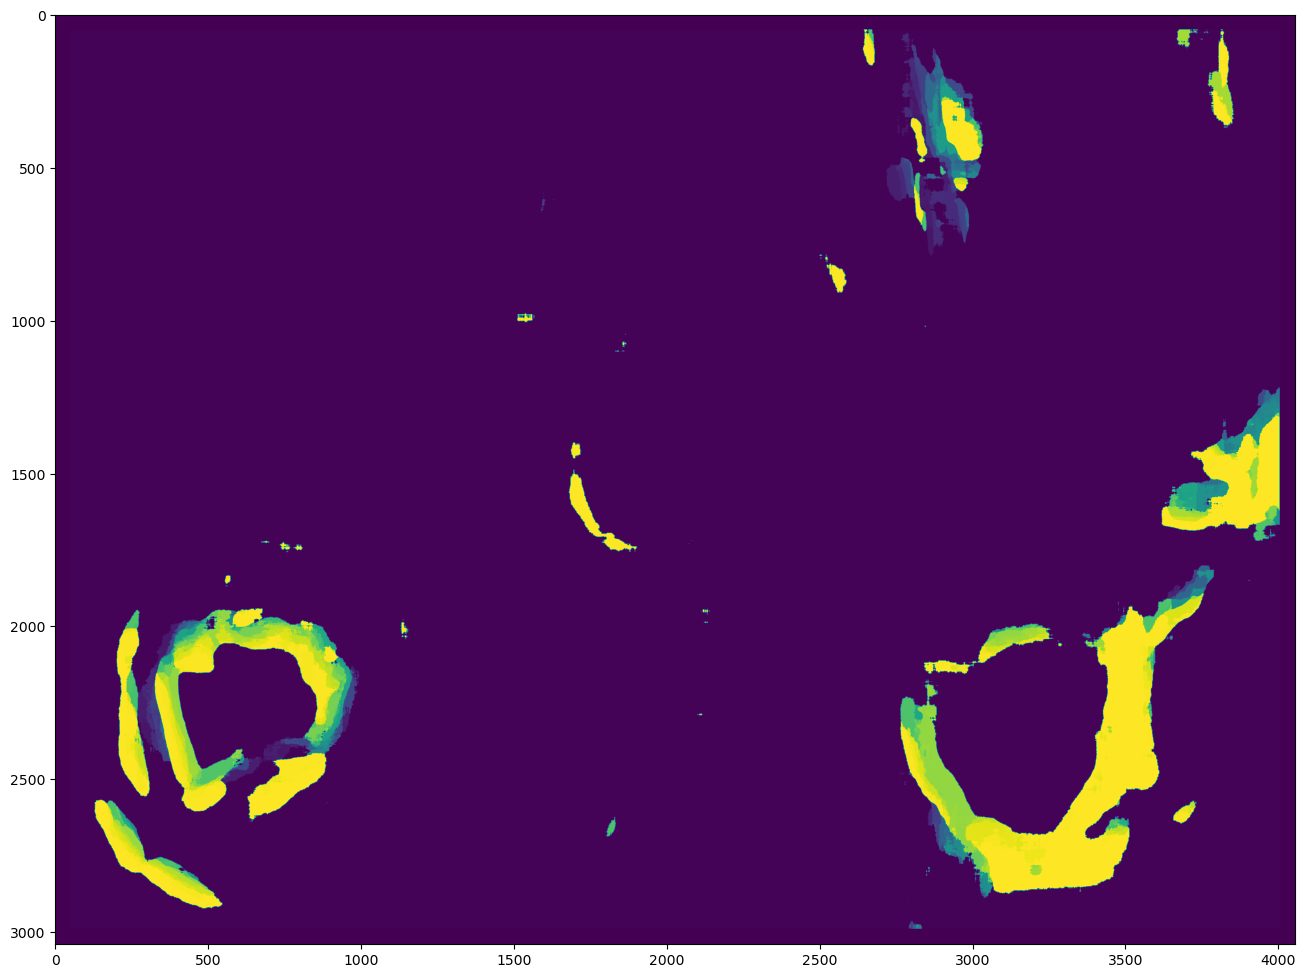

In [ ]:
fig = plt.figure(figsize=(16,16))
plt.imshow(m_t)


ValueError: s must be a scalar, or float array-like with the same size as x and y

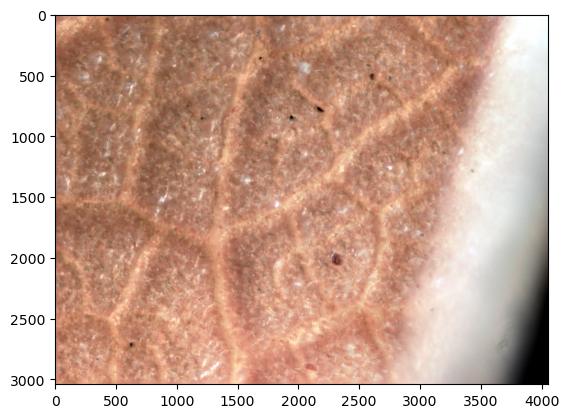

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

# Example image
image = plt.imread(completed_pictures+'hdr_result_2f.png')

(r, c, b) = np.shape(image)

# X and Y coordinates of points in the image, spaced by 10.
(X, Y) = np.meshgrid(range(0, c, 10), range(0, r, 10))

# Display the image
plt.imshow(image)
# Plot points from the image.
plt.scatter(X, Y, image[Y,X])
plt.show()


In [159]:
import open3d as o3d
data = np.array(Image.open(completed_pictures+'hdr_result_2f.tiff'))
depth_scale = 0.3875/0.15625 #px size in mu m , resoltuion of individual steps also mu m
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.io.read_image(completed_pictures+'hdr_result_2f.png'),o3d.io.read_image(completed_pictures+'depthmap.png'),
                                                          depth_scale=depth_scale, depth_trunc=1000)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd,o3d.camera.PinholeCameraIntrinsic(4056, 3040, 200, 200, 10, 10))

In [160]:
pcd.estimate_normals()
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

In [161]:
import trimesh
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 1.5 * avg_dist   

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
           pcd,
           o3d.utility.DoubleVector([radius, radius * 2]))

# create the triangular mesh with the vertices and faces from open3d
tri_mesh = trimesh.Trimesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles),
                          vertex_normals=np.asarray(mesh.vertex_normals))

trimesh.convex.is_convex(tri_mesh)

In [23]:
gray_projection = 'l-star'
contrast_window_size = 50
contrast_edge_scale = 0
os.chdir(os.path.join(img_dir,'preprocessed'))
 # Change naming convention
for i in ('262144mus', str(int(262144*1.5))+'mus', str(int(262144*0.5))+'mus', 'IR'):
    cmd = 'enfuse -o {}result_{}.tiff --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale=-0.1 *{}.tiff'.format(completed_pictures,i,gray_projection,contrast_window_size,i)
    os.system(cmd)

enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: info: input image "100_0_0_exp262144mus.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "10_0_0_exp262144mus.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "110_0_0_exp262144mus.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "120_0_0_exp262144mus.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "130_0_0_exp262144mus.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "140_0_0_exp262144mus.tiff" does not have an alpha channel;
enfuse: note: assuming all pixels should co

In [12]:
# Make HDR     _f so that it doesnt get read later
cmd = 'enfuse -o {}stack_hdr_f.tiff {}result_1.tiff {}result_0.5.tiff {}result_1.5.tiff'.format(completed_pictures,completed_pictures,completed_pictures,completed_pictures)
os.system(cmd)
cmd = 'enfuse -o {}stack_hdr_ir_f.tiff {}result_1.tiff {}result_0.5.tiff {}result_1.5.tiff {}result_IR.tiff'.format(completed_pictures,completed_pictures,completed_pictures,completed_pictures,completed_pictures)
os.system(cmd)

enfuse: failed to open "/home/felix/Pictures/whiteboard_eraser/completed/result_1.tiff": No such file or directory
enfuse: failed to open "/home/felix/Pictures/whiteboard_eraser/completed/result_1.tiff": No such file or directory


256